## 这个jupyter notebook的作用是跑出问题三baseline中题目所给四种模型的结果

### 下面这个block的作用是打出数据表中的所有列名，以便正确的作为模型的输入输出

In [4]:
import pandas as pd

import pandas as pd # type: ignore
# 显示所有列
pd.set_option('display.max_columns', None)
# # 显示所有行
pd.set_option('display.max_rows', None)  

# 加载数据
df1 = pd.read_csv("..\Data\data1.csv")
df2 = pd.read_csv("..\Data\data2.csv")

# 打印df1的所有列名
print("df1列名:")
print(df1.columns)

# 打印df2的所有列名
print("\ndf2列名:")
print(df2.columns)


df1列名:
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'Y(1=default, 0=non-default)'],
      dtype='object')

df2列名:
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'Y(1=default, 0=non-default)'],
      dtype='object')


## 为了提高模型训练速度，下面是一个简化版本（但是对于df2的支持向量机训练进度仍旧很慢，故添加可视化进度条）

Training Progress:   0%|          | 0/7 [00:00<?, ?it/s]


DecisionTree on df1:
Confusion Matrix:
[[159  50]
 [ 40  51]]
AUC: 0.662
Accuracy: 0.700
Type I Error: 0.239
Type II Error: 0.440


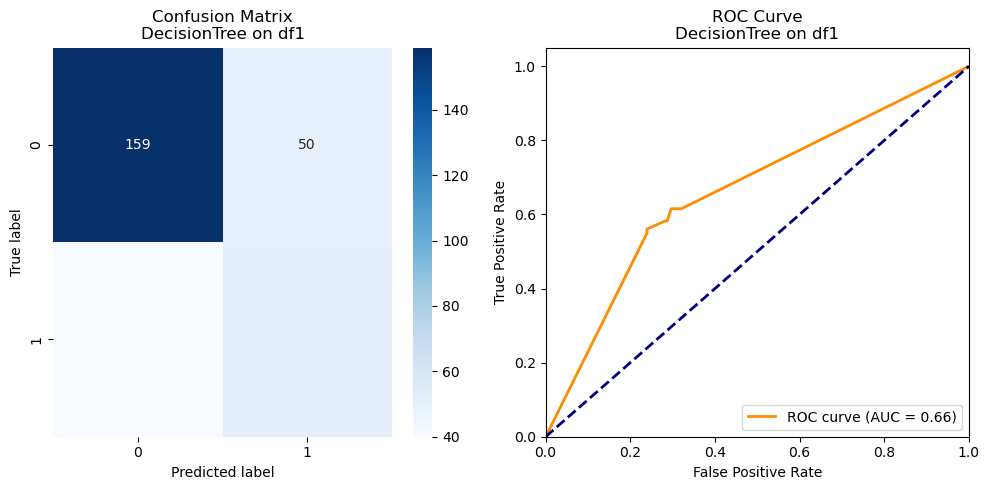

Training Progress:  14%|█▍        | 1/7 [00:00<00:03,  1.85it/s]


KNN on df1:
Confusion Matrix:
[[189  20]
 [ 53  38]]
AUC: 0.748
Accuracy: 0.757
Type I Error: 0.096
Type II Error: 0.582


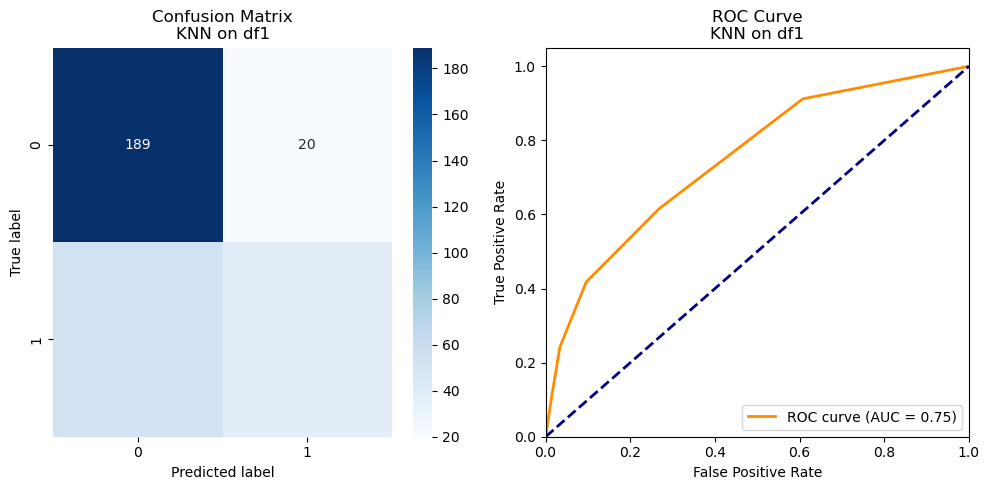

Training Progress:  29%|██▊       | 2/7 [00:01<00:04,  1.14it/s]


RandomForest on df1:
Confusion Matrix:
[[178  31]
 [ 49  42]]
AUC: 0.752
Accuracy: 0.733
Type I Error: 0.148
Type II Error: 0.538


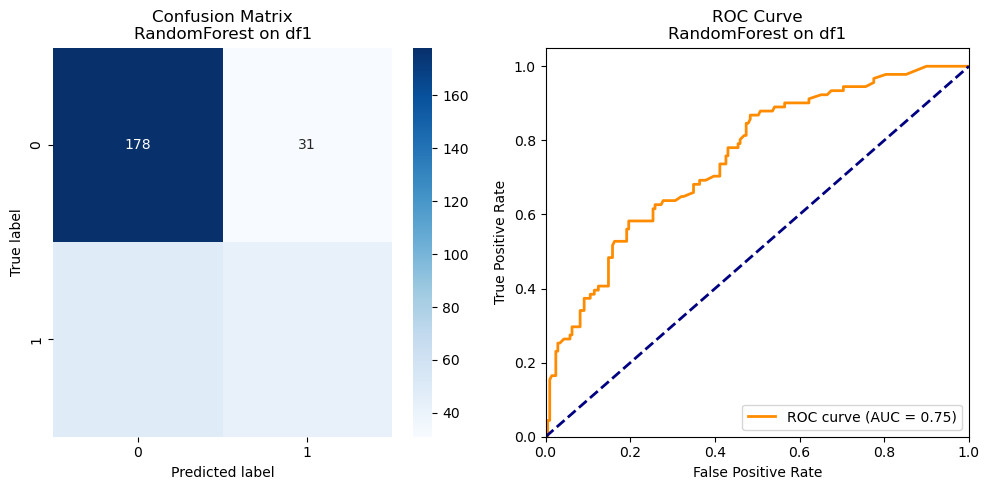

Training Progress:  43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]


SVM on df1:
Confusion Matrix:
[[193  16]
 [ 59  32]]
AUC: 0.810
Accuracy: 0.750
Type I Error: 0.077
Type II Error: 0.648


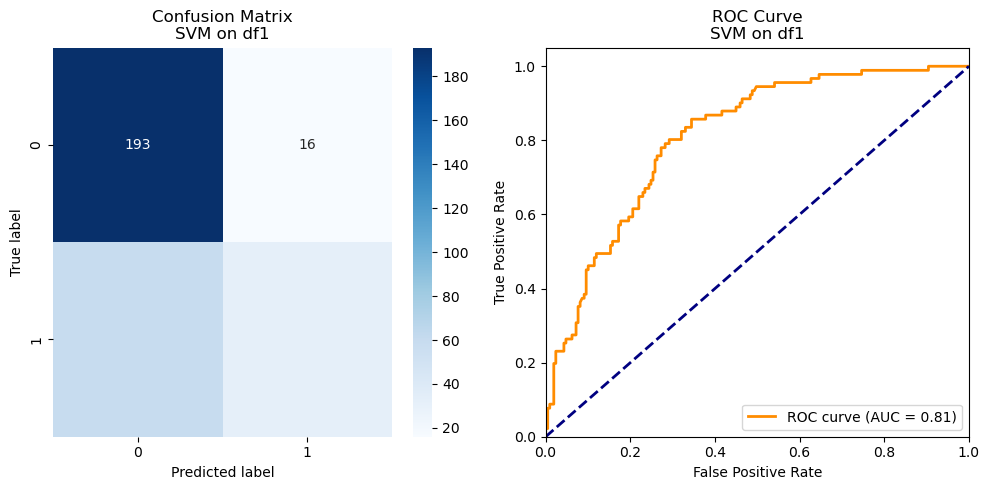

Training Progress:  57%|█████▋    | 4/7 [00:03<00:02,  1.34it/s]


DecisionTree on df2:
Confusion Matrix:
[[ 64  17]
 [ 16 110]]
AUC: 0.832
Accuracy: 0.841
Type I Error: 0.210
Type II Error: 0.127


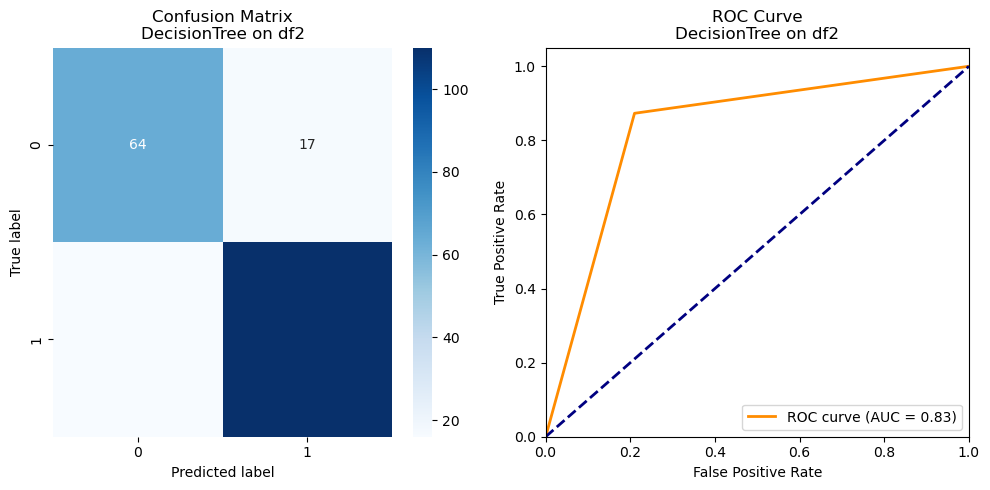

Training Progress:  71%|███████▏  | 5/7 [00:03<00:01,  1.47it/s]


KNN on df2:
Confusion Matrix:
[[ 58  23]
 [ 21 105]]
AUC: 0.833
Accuracy: 0.787
Type I Error: 0.284
Type II Error: 0.167


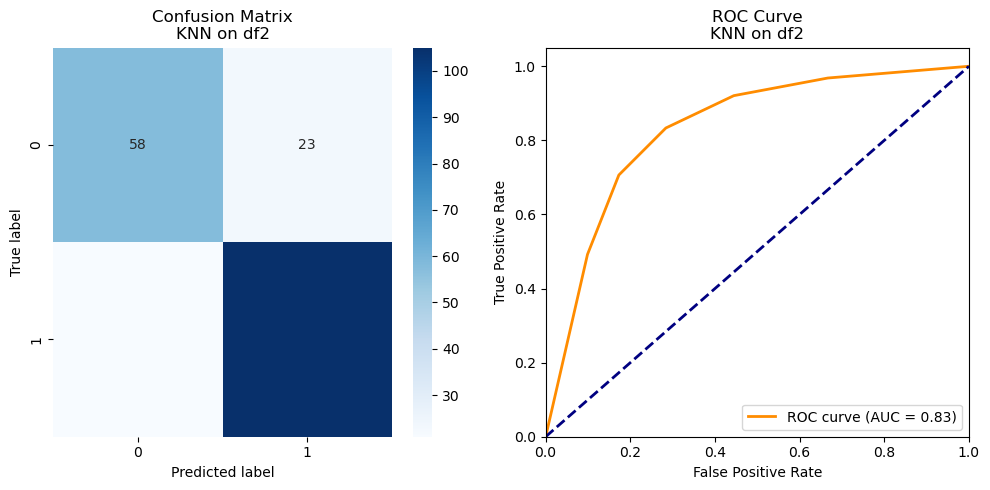

Training Progress:  86%|████████▌ | 6/7 [00:04<00:00,  1.58it/s]


RandomForest on df2:
Confusion Matrix:
[[ 66  15]
 [ 15 111]]
AUC: 0.920
Accuracy: 0.855
Type I Error: 0.185
Type II Error: 0.119


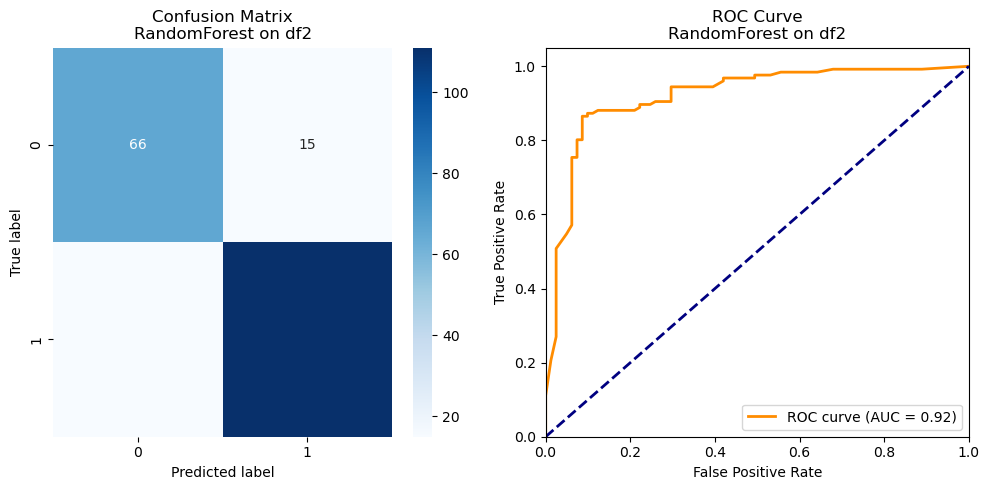

Training Progress: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Results have been saved to '../Data/Q3_model_performance_metrics.csv'


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df1 = pd.read_csv("../Data/data1.csv")
df2 = pd.read_csv("../Data/data2.csv")

# Prepare data
X1 = df1.loc[:, 'X1':'X24']
y1 = df1['Y(1=default, 0=non-default)']
X2 = df2.loc[:, 'X1':'X14']
y2 = df2['Y(1=default, 0=non-default)']

# Feature selection
selector = SelectKBest(f_classif, k=10)
X1_selected = selector.fit_transform(X1, y1)
X2_selected = selector.fit_transform(X2, y2)

# Define classifiers
classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Function to train and evaluate model
def train_and_evaluate_model(X, y, classifier_name, classifier):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    type1_error = fp / (fp + tn)
    type2_error = fn / (fn + tp)
    
    return cm, fpr, tpr, roc_auc, accuracy, type1_error, type2_error

# Visualization function
def plot_results(dataset_name, classifier_name, cm, fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix\n{classifier_name} on {dataset_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve\n{classifier_name} on {dataset_name}')
    plt.legend(loc="lower right")
    
    plt.savefig(f'../Data/Q3_{classifier_name}_{dataset_name}.png')
    plt.tight_layout()
    plt.show()

# Create a dictionary to store all metrics
results = {
    'Dataset': [],
    'Classifier': [],
    'Accuracy': [],
    'AUC': [],
    'Type1-error': [],
    'Type2-error': []
}

# Use tqdm to show progress bar
total_iterations = len(classifiers) + len(classifiers) - 1  # Subtract 1 for SVM on df2
with tqdm(total=total_iterations, desc='Training Progress') as pbar:
    for dataset_name, X, y in [("df1", X1_selected, y1), ("df2", X2_selected, y2)]:
        for name, classifier in classifiers.items():
            # Skip SVM for df2
            if dataset_name == "df2" and name == "SVM":
                continue
            
            cm, fpr, tpr, roc_auc, accuracy, type1_error, type2_error = train_and_evaluate_model(X, y, name, classifier)
            print(f"\n{name} on {dataset_name}:")
            print(f"Confusion Matrix:\n{cm}")
            print(f"AUC: {roc_auc:.3f}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Type I Error: {type1_error:.3f}")
            print(f"Type II Error: {type2_error:.3f}")
            
            results['Dataset'].append(dataset_name)
            results['Classifier'].append(name)
            results['Accuracy'].append(accuracy)
            results['AUC'].append(roc_auc)
            results['Type1-error'].append(type1_error)
            results['Type2-error'].append(type2_error)
            
            plot_results(dataset_name, name, cm, fpr, tpr, roc_auc)
            
            pbar.update(1)

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('../Data/Q3_model_performance_metrics.csv', index=False)
print("\nResults have been saved to '../Data/Q3_model_performance_metrics.csv'")

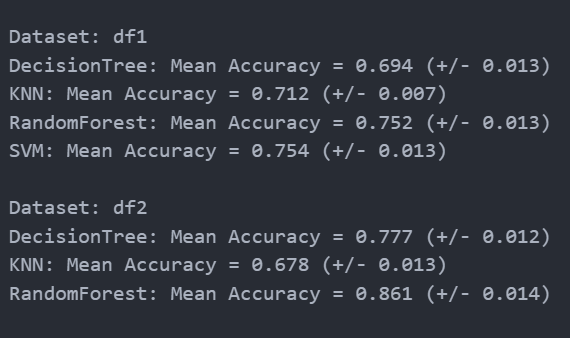